# Imports

In [ ]:
##################################
#   Mount Drive to Save Models   #
##################################

from google.colab import drive
drive.mount('/content/drive')

# Folder path to where models will be saved
# Note: folders must already exist to save them there
folder_path = './drive/My Drive/SAT/Empathy classifier/'
models_path = folder_path + 'models/'
data_path = folder_path + 'empathy_classifier_data/'

Mounted at /content/drive


In [ ]:
!pip install transformers==4.28.0 datasets wandb nltk

import pandas as pd
import datasets
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments, AdamW, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import wandb
import os
import nltk
import random
from random import shuffle
from sklearn.utils import resample

from datetime import datetime
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 27.9 MB/s eta 0:00:00
  Preparing metada

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Load and pre-process dataset

In [ ]:
val_percent = 0.8

### Load with splits

In [ ]:
# Get data
personas_train_splits_file_path = data_path + 'my_train.txt'
sharma_train_splits_file_path = data_path + 'train.txt'
train_paths = [personas_train_splits_file_path, sharma_train_splits_file_path]

personas_test_splits_file_path = data_path + 'my_test.txt'
sharma_test_splits_file_path = data_path + 'test.txt'
test_paths = [personas_test_splits_file_path, sharma_test_splits_file_path]

personas_val_splits_file_path = data_path + 'my_val.txt'
sharma_val_splits_file_path = data_path + 'val.txt'
val_paths = [personas_val_splits_file_path, sharma_val_splits_file_path]

train_df = pd.concat((pd.read_csv(f, sep=";", header=None) for f in train_paths), ignore_index=True)
test_df =  pd.concat((pd.read_csv(f, sep=";", header=None) for f in test_paths), ignore_index=True)
val_df =   pd.concat((pd.read_csv(f, sep=";", header=None) for f in val_paths), ignore_index=True)

In [ ]:
train_df = train_df.set_axis(['text', 'label'], axis=1, inplace=False)
test_df = test_df.set_axis(['text', 'label'], axis=1, inplace=False)
val_df = val_df.set_axis(['text', 'label'], axis=1, inplace=False)

<ipython-input-4-74306a1f3a85>:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  train_df = train_df.set_axis(['text', 'label'], axis=1, inplace=False)
<ipython-input-4-74306a1f3a85>:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  test_df = test_df.set_axis(['text', 'label'], axis=1, inplace=False)
<ipython-input-4-74306a1f3a85>:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  val_df = val_df.set_axis(['text', 'label'], axis=1, inplace=False)


In [ ]:
train_df['label'] = train_df['label'].replace(['no','weak','strong'],[0,1,2])
test_df['label'] = test_df['label'].replace(['no','weak','strong'],[0,1,2])
val_df['label'] = val_df['label'].replace(['no','weak','strong'],[0,1,2])

In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)

In [ ]:
print(train_df.head(5))

                                                text  label
0  Hi there. No one on this earth is worthless, e...      2
1  Dear Anna_rampage. Thank you for your kind wor...      2
2  I always think that other ppl have great lives...      0
3  Could your sadness be related to some bigger p...      1
4  I'm so sorry you're going through this.. My do...      2


### Analysis

In [ ]:
train_df.describe()

,label
count,935.000000
mean,1.036364
std,0.804673
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


### Load into datasets

In [ ]:
# With splits
train_data = datasets.Dataset.from_pandas(train_df)
val_data = datasets.Dataset.from_pandas(val_df)
test_data = datasets.Dataset.from_pandas(test_df)

In [ ]:
train_data['text'][0]

'Could your sadness be related to some bigger problem, like an intpersonal crisis between you and your loved ones?'

# Load model and tokenise

In [ ]:
# load model and tokenizer and define length of the text sequence
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512) # max that a bert model can take

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
# Define a function that will tokenize the model, and will return the relevant inputs for the model
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = 'max_length', truncation=True)

# Tokenise train_data and test_data
train_data = train_data.map(tokenization, batched = True, batch_size = len(train_data))
val_data = val_data.map(tokenization, batched = True, batch_size = len(val_data))
test_data = test_data.map(tokenization, batched = True, batch_size = len(test_data))

Map:   0%|          | 0/3248 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/728 [00:00<?, ? examples/s]

In [ ]:
# Set column names and types
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
# Should show 'input_ids', 'attention_mask', 'text' and 'labels'
train_data

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3248
})

# Metrics

In [ ]:
# define accuracy metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'f1': f1,
        'accuracy': acc,
        'precision': precision,
        'recall': recall
    }

# Custom Layer-wise LR Decay Optimiser
Adapted from: https://towardsdatascience.com/advanced-techniques-for-fine-tuning-transformers-82e4e61e16e#:~:text=Layer%2Dwise%20Learning%20Rate%20Decay%20(LLRD),-In%20Revisiting%20Few&text=This%20is%20accomplished%20by%20setting,layer%20from%20top%20to%20bottom%E2%80%9D.

In [ ]:
def roberta_base_AdamW_grouped_LLRD(model):

    opt_parameters = []
    # To be passed to the optimizer (only parameters of the layers you want to update).
    named_parameters = list(model.named_parameters())

    # According to AAAMLP book by A. Thakur, we generally do not use any decay
    # for bias and LayerNorm.weight layers.
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    set_2 = ["layer.4", "layer.5", "layer.6", "layer.7"]
    set_3 = ["layer.8", "layer.9", "layer.10", "layer.11"]
    init_lr = 1.35e-4

    for i, (name, params) in enumerate(named_parameters):

        weight_decay = 0.0 if any(p in name for p in no_decay) else 0.01

        if name.startswith("roberta.embeddings") or name.startswith("roberta.encoder"):
            # For first set, set lr to 1e-6 (i.e. 0.000001)
            lr = init_lr

            # For set_2, increase lr to 0.00000175
            lr = init_lr * 1.75 if any(p in name for p in set_2) else lr

            # For set_3, increase lr to 0.0000035
            lr = init_lr * 3.5 if any(p in name for p in set_3) else lr

            opt_parameters.append({"params": params,
                                   "weight_decay": weight_decay,
                                   "lr": lr})

        # For regressor and pooler, set lr to 0.0000036 (slightly higher than the top layer).
        if name.startswith("regressor") or name.startswith("roberta.pooler"):
            lr = init_lr * 3.6

            opt_parameters.append({"params": params,
                                   "weight_decay": weight_decay,
                                   "lr": lr})

    return AdamW(opt_parameters, lr=init_lr)

In [ ]:
optimizer = roberta_base_AdamW_grouped_LLRD(model)

scheduler = get_cosine_schedule_with_warmup(
                optimizer = optimizer,
                num_warmup_steps = 300,
                num_training_steps = 4 * 406) # epochs * samples / batch size (num of batches)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Trainer API Set Up

In [ ]:
# Name in wandb
run_name = 'roberta-empathy-' + datetime.now().strftime("%d/%m/%Y-%H:%M:%S")
print("Name of run: " + run_name)

output_dir = models_path + 'results'
logging_dir = models_path + 'logs'

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs = 6,
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 4,
    per_device_eval_batch_size = 8,
    evaluation_strategy = "epoch",        # evaluate at the end of training epoch
    save_strategy = "epoch",
    save_total_limit=2,                   # Delete model checkpoints that don't have the highest metric
    disable_tqdm = False,
    load_best_model_at_end=True,          # Load best model for evaluation according to defined metrics
    metric_for_best_model="eval_f1",      # Use f1 to determine the best model (default is loss)
    warmup_steps=90,
    # learning_rate=0.0002,
    # weight_decay=0.00001,
    logging_steps = 4,
    # fp16 = True,                        # Half precision (16-bit) floating point format. Reduces training time needed.
    # optim="adamw_hf",
    logging_dir=logging_dir,              # log to wandb
    dataloader_num_workers = 2,           # originally 8 but google colab gave a warning that 2 was recommended
    run_name=run_name,
    report_to="wandb"
)

Name of run: roberta-empathy-11/06/2023-10:00:56


In [ ]:
# REMOVES ALL CHECKPOINTS FROM PREVIOUS RUNS
# Check if you need them first
# !rm -r ./drive/"My Drive"/NLP/models/results

In [ ]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    optimizers = (optimizer, scheduler),
    train_dataset=train_data,
    eval_dataset=val_data
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Training and evaluation

In [ ]:
# train the model
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
0,1.102200,1.089157,0.192982,0.407407,0.135802,0.333333
1,1.085400,1.033023,0.290114,0.444444,0.246154,0.373737
2,0.957200,0.847283,0.466184,0.611111,0.411172,0.543771
3,0.859700,0.697901,0.596975,0.666667,0.763077,0.615200
4,0.754500,0.611319,0.755201,0.759259,0.802469,0.739538
5,0.619500,0.591659,0.736060,0.759259,0.784420,0.728956


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=42, training_loss=0.9161712527275085, metrics={'train_runtime': 503.5098, 'train_samples_per_second': 11.142, 'train_steps_per_second': 0.083, 'total_flos': 1413182166617088.0, 'train_loss': 0.9161712527275085, 'epoch': 5.74})

In [ ]:
# Path to best checkpoint
best_ckpt_path = trainer.state.best_model_checkpoint

print("Best Checkpoint (According to Trainer): " + best_ckpt_path)

Best Checkpoint (According to Trainer): ./drive/My Drive/SAT/Empathy classifier/models/results/checkpoint-36


In [ ]:
# Save current (not best) model to folder
trainer.save_model(models_path + 'saved/' + run_name.replace('/', '-'))

# Test model

In [ ]:
# Reload model
model_reload_path = models_path + 'saved/roberta-empathy-03-06-2023-18:21:58'
# model_reload_path = models_path + 'results/checkpoint-150'

model = RobertaForSequenceClassification.from_pretrained(model_reload_path, local_files_only=True)
model.to('cuda')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
test_trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512)

In [ ]:
test_trainer.evaluate(eval_dataset=test_data)

{'eval_loss': 0.3576347529888153,
 'eval_f1': 0.8737203216314798,
 'eval_accuracy': 0.873581847649919,
 'eval_precision': 0.8760691525514975,
 'eval_recall': 0.8748313090418355,
 'eval_runtime': 17.3379,
 'eval_samples_per_second': 35.587,
 'eval_steps_per_second': 4.499}

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
import matplotlib.pyplot as plt
import numpy
import torch.nn.functional as F
from sklearn import metrics

# Dataset must have been built and saved to csv_file_path earlier
# csv_dev_splits_processed_file_path = folder_path + 'dev-splits/dev-split-processed.csv'

# Load test data
data = test_df
X_all = list(data["text"])
X_test_tokenized = tokenizer(X_all, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Make prediction
raw_preds, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_preds = np.argmax(raw_preds, axis=1)

# Get true values
y_all = list(data["label"])
y_true = y_all

# Calculate ROC and Confusion Matrix
Adapted from: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

In [ ]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations

    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes

    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''

    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

In [ ]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.

    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.

    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).

    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

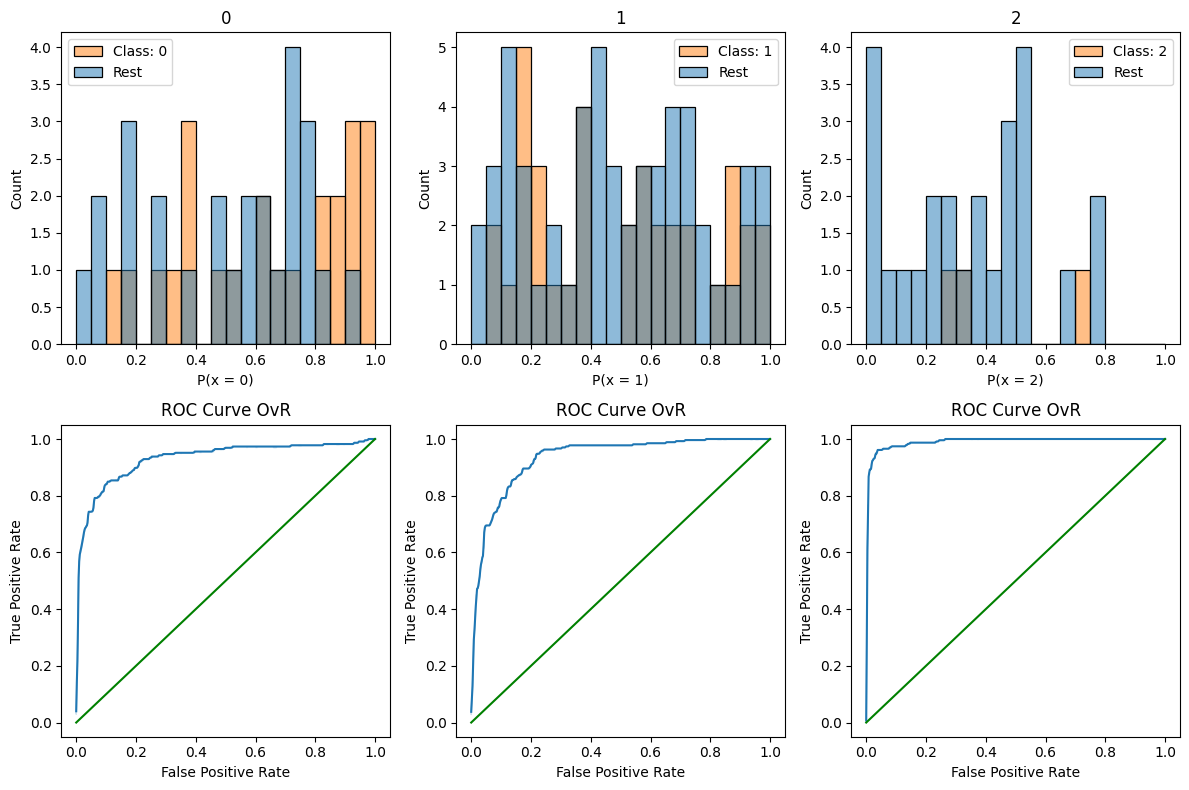

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = [0, 1, 2]
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame()
    df_aux['class'] = [1 if y == c else 0 for y in y_true]
    df_aux['prob'] = raw_preds[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [ ]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

0 ROC AUC OvR: 0.9303
1 ROC AUC OvR: 0.9322
2 ROC AUC OvR: 0.9894
average ROC AUC OvR: 0.9507


In [ ]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])

<ipython-input-38-06759028605a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]


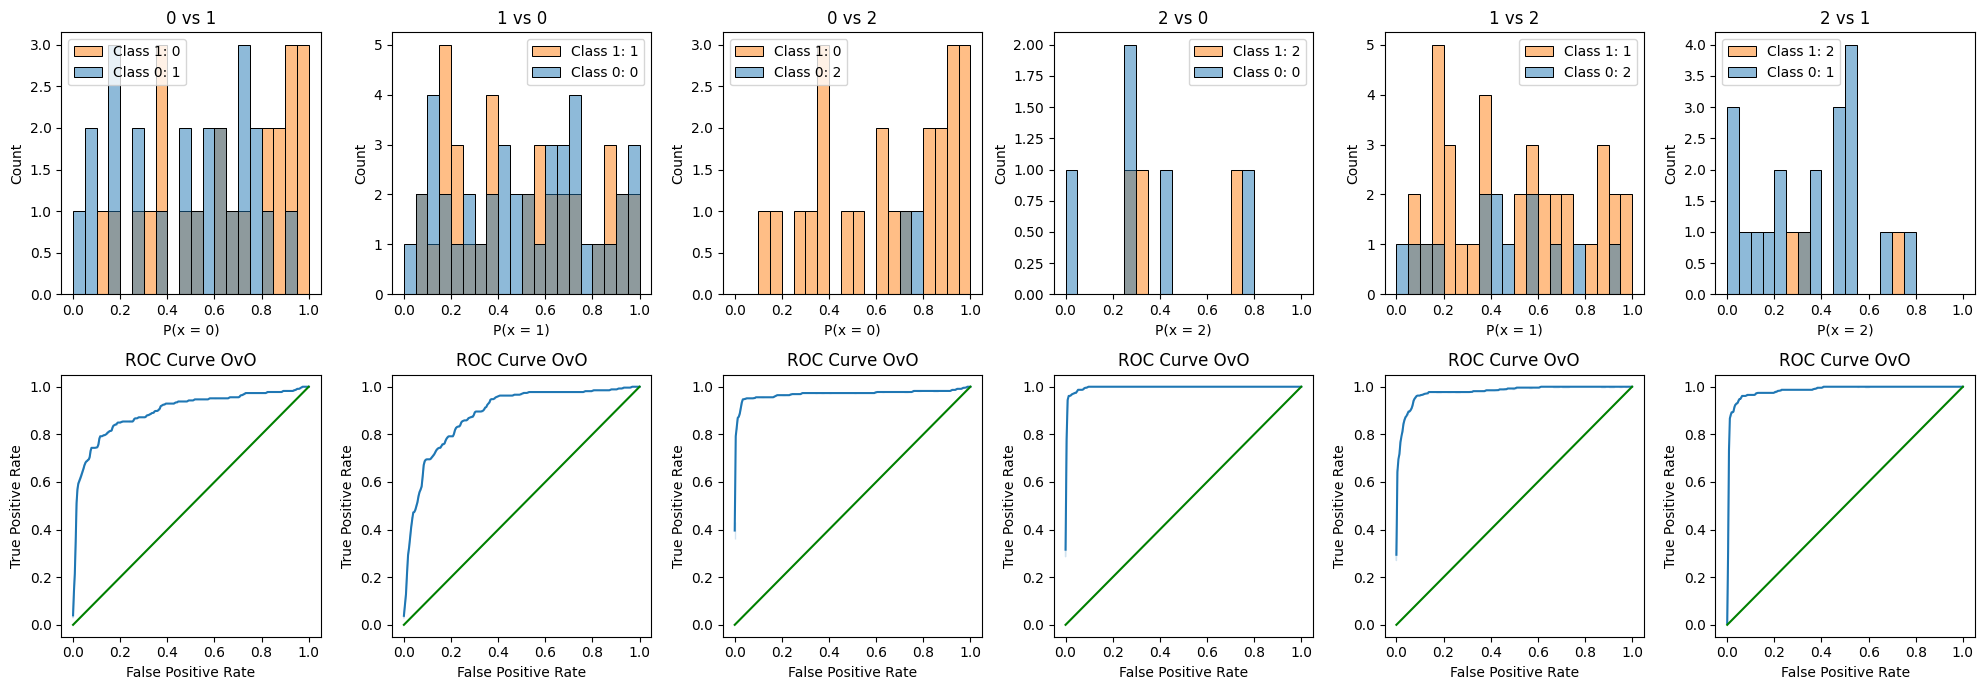

In [ ]:
#Plots the Probability Distributions and the ROC Curves One vs One
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}
for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = str(c1) + " vs " + str(c2)

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame()
    df_aux['class'] = y_true
    df_aux['prob'] = raw_preds[:, c1_index]

    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")

    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [ ]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

0 vs 1 ROC AUC OvO: 0.8958
1 vs 0 ROC AUC OvO: 0.8850
0 vs 2 ROC AUC OvO: 0.9702
2 vs 0 ROC AUC OvO: 0.9963
1 vs 2 ROC AUC OvO: 0.9780
2 vs 1 ROC AUC OvO: 0.9836
average ROC AUC OvO: 0.9515


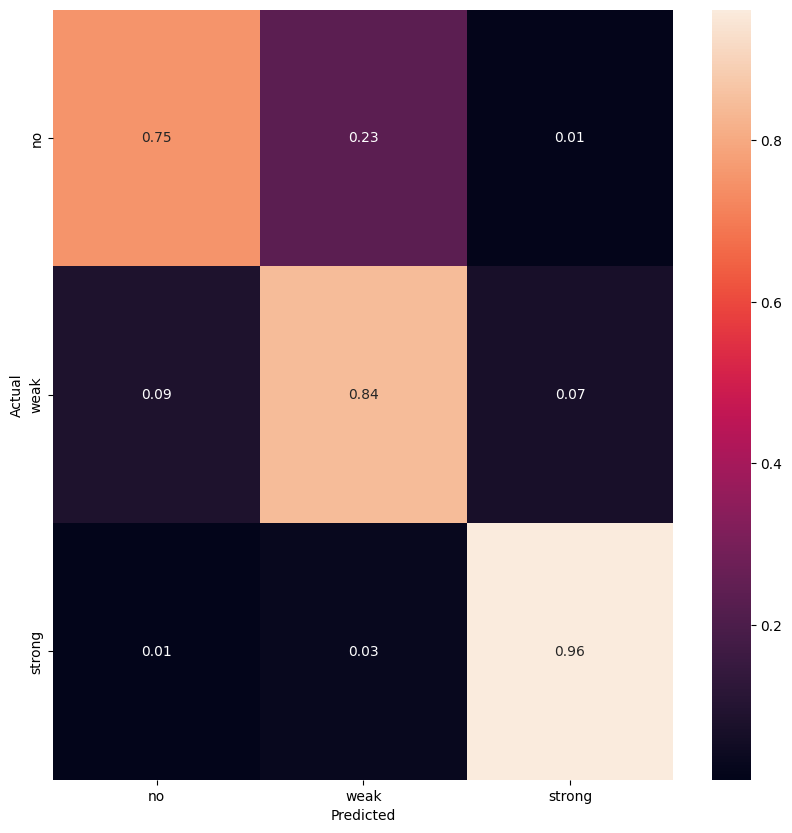

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_preds)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['no', 'weak', 'strong'], yticklabels=['no', 'weak', 'strong'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, fscore, _ = precision_recall_fscore_support(y_true, y_preds)

print(prec)
print(rec)
print(fscore)

[0.87179487 0.79094077 0.91056911]
[0.75221239 0.84386617 0.96137339]
[0.80760095 0.81654676 0.93528184]
